# ЭКСПЕРИМЕНТ С ОДИНОЧНЫМ ДЕСКРИПТОРОМ
1. Извлечём признаки только из одной фотографии и поспытаемся найти лица с похожими признаками на видео. 
2. В качестве критерия схожести - будем использовать евклидово расстояние между векторами. 
3. Порогом будет значение 0.6
4. Найденные фрагменты видео с заданным порогом объеденим в одно видео и сохраним в папке single_result. В этой же папке сохраним список всех кадров, где был найден Джим Керри.
5. Т.к. для 20 минутного видео нам потребуется 24.3 GiB только на массив numpy, а таких ресурсов у нас нет - обрежим тестовое видео до 3 минут.

## Решение
Решение полностью выполняет поставленное перед собой задание, однако подход возможно несколько другой, чем Вы ожидали.
Стоит посмотреть на результирующем видео на 22 секунду 'result.mp4', оценить скорость выполнения и краткость кода, 
и желание искать другой подход на 90% отпадает.
Крайне важным являются следующие моменты:
* для образца нужна только одна фотография, что ближе к реальным, жизненным условиям.
* скорость выполнения
* краткость кода
* возможность выделения и сохранения найденных лиц

Понятно, что если усреднить вектор по множеству изображений - точность будет выше.

Ещё один момент - большинство победителей на Kaggle используют готовые модели, а не изобретают велосипед.
Мой подход - аналогичен. Я использовал библиотеку dlib. Считаю её одной из лучших.


## Технические ограничения
Рекомендуется запуск на **google colab**, т.к. там настроена вся необходимая среда.
Крайне не рекомендуется запускать на Windows - потребуется установить и настроить кучу зависимостей для dlib, Visual Studio, C++ - Packages CMake tools для Windows, ffmpeg, настроить переменные среды и др.

Для 20 минутного видео необходим объём ОЗУ 24 гигабайта только на тензор видео. Таких ресурсов у меня нет. Обрезал видео до 3 минут и смог запустить пример на google colab

## Эксперимент

Файл: main.ipynb

Как это работает:

1. Загружаем фотографию Джима Керри в анфас с хорошим качеством и типичным изображением лица.
2. С помощью dlib извлекаем признаки и формируем 128 разрядный вектор признаков.
3. Проходим по всем кадрам видео, проверяем каждый кадр на наличие лиц.
4. Если лицо найдено - вычисляем вектор признаков.
5. Находим Евклидово расстояние между вектором лица Джима Керри и найденным вектором.
6. Если Евклидово расстояние менее порога (0.6) - это Джим Керри, помещаем индекс кадров в список DAN.frame_list
7. Перебираем все кадры видео и если текущий кадр есть в списке кадров DAN.frame_list - помещаем тензор кадра в список
8. Переводим список тензоров в тензор numpy 4 ранга и сохраняем видео и выводим данные.

## Author
Domnenko Aleksey 2021
*   telegram: @domnenko_a_n
*   email: domnenko@mail.ru



## Внимание!
Не забудьте указать в настройках свои пути до папок.

================================================================================


# ПОДКЛЮЧЕНИЕ

## Установка необходимых пакетов

In [1]:
!pip install -q sk-video

     |████████████████████████████████| 2.3MB 9.5MB/s 


## Подключение пакетов

In [2]:
import os.path
import time
import pandas as pd
import numpy as np
from skimage import io  # Загрузка изображения
import skvideo.io  # Загрузка видео
from scipy.spatial import distance  # Расчёт Евклидового расстояния
from IPython.display import HTML  # Для просмотра видео
from base64 import b64encode  # Для отображения видео в HTML
import matplotlib.pyplot as plt
import dlib  # Поиск и выделение лиц

## Монтируем Google drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# НАСТРОЙКИ

In [4]:
# --- ВНИМАНИЕ! ---
# Укажите свой путь до папки с файлами
DIR = '/content/drive/MyDrive/Colab Notebooks/ОБУЧЕНИЕ/УИИ/Поиск Джима Керри на видео/files'  # Абсолютный путь до папки с файлами
FRAME_TEST_LIST = [200, 300, 400]  # Индексы тестовых кадров

# КЛАСС ДЛЯ РАБОТЫ С ВИДЕОРОЛИКОМ

### **Метод __init__()**
Настройки и инициализация объектов dlib

**shape_predictor**

Этот объект представляет собой инструмент, который берет область изображения, содержащую некоторый объект, и выводит набор точек, определяющих позу объекта. Классическим примером этого является прогнозирование позы человеческого лица, когда вы берёте изображение человеческого лица в качестве входных данных и, как ожидается, определите расположение важных лицевых ориентиров, таких как уголки рта и глаз, кончик носа и т. Д. вперед.

**face_recognition_model_v1**

Этот объект переводит человеческие лица в 128 разрядные векторы, где изображения одного и того же человека расположены рядом друг с другом, а изображения разных людей нанесены на карту далеко друг от друга. Конструктор загружает модель распознавания лиц из файла

**get_frontal_face_detector**

Возвращает детектор лиц по умолчанию. Координаты лица, обнаруженного на изображении

### **Метод getRectangle()**

Получаем тензор, содержащий только область лица.
Возвращает тензор изображения и дескриптор.

### **Метод euclideanDistance()**
Рассчитываем Евклидово расстояние между векторами и возвращаем меру схожести.

### **Метод saveMovie()**
Получает сохраняет виеоролик с кадрами из списка self.frame_lis

### **Метод showImage()**
Отображает 3 изображения из входного списка


In [5]:
class DanFace:
  def __init__(self):
    self.frame_list = []  # Список кадров, на которых был найден Джим Керри, 
    self.frame_list_file = os.path.join(DIR, 'result', 'frame_list.csv')  # Имя файла в котором сохраняются индексы кадров с Джимом Керри
    self.output_video_file = os.path.join(DIR, 'result', 'result.mp4')
    with open(self.frame_list_file, 'tw', encoding='utf-8') as f:  # Создаём пустой файл
      pass
    self.threshold = 0.6
    self.sp = dlib.shape_predictor(os.path.join(DIR, 'dlib_models', 'shape_predictor_68_face_landmarks.dat'))
    self.facerec = dlib.face_recognition_model_v1(os.path.join(DIR, 'dlib_models', 'dlib_face_recognition_resnet_model_v1.dat'))
    self.detector = dlib.get_frontal_face_detector()


  # Получаем тензор, содержащий только область лица. Возвращает список тензоров изображения и дескрипторов.
  def getRectangle(self, image_np):  # save - True / False - сохранять изображения и записывать дескрипторы
    # Находим изображение
    face_coord_list = self.detector(image_np, 1)  # Возвращает список координат найденных лиц
    # Перебираем все найденные лица на изображении
    img_rect_list = []
    face_descriptor_list = []
    for coord in face_coord_list:
      img_rect = image_np[coord.top():coord.bottom(), coord.left():coord.right()]  # Тензор лица
      img_rect_list.append(img_rect)
      shape = self.sp(image_np, coord)  # Получаем набор ключевых точек
      face_descriptor = self.facerec.compute_face_descriptor(image_np, shape)  # Извлекаем дескриптор из лица
      face_descriptor_list.append(face_descriptor)
    return img_rect_list, face_descriptor_list   # Возвращаем список изображений и дескрипторов


  # Рассчитываем Евклидово расстояние между векторами и возвращаем меру схожести
  def euclideanDistance(self, vector_1, vector_2):
    return distance.euclidean(vector_1, vector_2)


  def saveMovie(self, video_np):
    frame_list = []  # Список кадров с Джимом Керри
    for i, frame in enumerate(video_np):
      if i in self.frame_list:
        frame_list.append(frame)
    video_np = np.array(frame_list, dtype=np.float32) 
    print(video_np.shape)
    output = video_np.astype(np.uint8)
    skvideo.io.vwrite(self.output_video_file, output)


  # Отображение 3х изображений
  def showImage(self, image_list):
    fig, axs = plt.subplots(1, 3, figsize=(25, 10))
    axs[0].imshow(image_list[0])
    axs[1].imshow(image_list[1])
    axs[2].imshow(image_list[2])

In [6]:
DAN = DanFace()

# ОБУЧЕНИЕ
Загружаем одиночную фотографию Джима Керри, находим лицо и находим для него вектор описания лица

## Загружаем фотографию Джима Керри

In [7]:
img_dk = io.imread(os.path.join(DIR, 'images', 'example.jpg'))

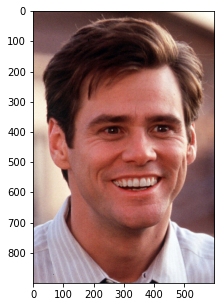

In [8]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
ax.imshow(img_dk)

## Находим лицо и дескриптор лица Джима Керри

In [9]:
img_list, desc_list = DAN.getRectangle(img_dk)
img_dk_0 = img_list[0]
desc_dk_0 = desc_list[0]

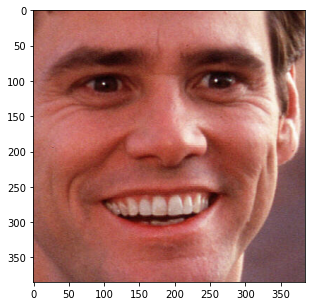

In [10]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
ax.imshow(img_dk_0)

In [11]:
# Выведем вектор описания
print(desc_dk_0)

-0.0541373
0.202587
-0.0298097
-0.00926627
-0.116785
0.0738149
-0.0692535
-0.0604416
0.200516
0.0241517
0.188362
0.0497336
-0.247466
0.0218955
-0.0516502
0.129127
-0.207529
-0.0803472
-0.12283
-0.0406401
0.0490773
0.0820659
0.0444198
0.0884188
-0.134346
-0.300473
-0.0688163
-0.170351
0.0137635
-0.201302
0.00474814
-0.0300113
-0.200617
-0.101022
0.0118437
0.0720463
-0.16506
-0.111789
0.210489
0.102883
-0.101709
0.0340384
0.0170561
0.339244
0.189672
0.00765976
-0.00553736
-0.0732035
0.108305
-0.256245
0.11208
0.158179
0.109891
0.187468
0.0827237
-0.157786
0.0752194
0.149681
-0.187432
0.0476096
0.0663512
-0.0123138
-0.0131067
-0.0300889
0.193137
0.122136
-0.0276699
-0.142692
0.0750621
-0.0783456
-0.11769
0.101535
-0.133432
-0.190072
-0.270526
0.0408481
0.39564
0.153582
-0.16791
-0.060541
-0.113282
-0.0466094
0.0319692
-0.0656083
-0.0813186
-0.0605572
-0.10241
0.0989437
0.204906
-0.023819
-0.080422
0.198829
0.025887
-0.0354209
0.066637
0.028574
-0.0823263
0.0186845
-0.169425
-0.0750815
0.0

## Найдём евклидово расстояние для этой фотографии 
Должно быть = 0, т.к. это одна и та же фотография

In [12]:
img_test_list, desc_test_list = DAN.getRectangle(img_dk)
img_test_0 = img_test_list[0]
desc_test_0 = desc_test_list[0]

Джим Керри: ДА, Евклидово расстояние: 0.0


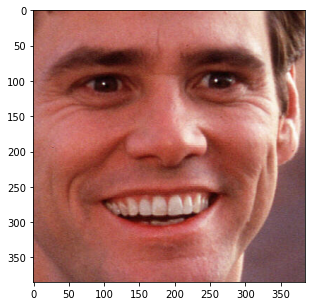

In [13]:
dist = DAN.euclideanDistance(desc_test_0, desc_dk_0)
answer = 'ДА' if dist < DAN.threshold else 'НЕТ'
print(f'Джим Керри: {answer}, Евклидово расстояние: {round(dist, 4)}')

fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
ax.imshow(img_test_0)

## Проверка расчёта расстояния
Проверка сравнения примера с самим собой прошла успешно!

## Загружаем тестовое видео

In [14]:
video_np = skvideo.io.vread(os.path.join(DIR, 'video', 'test_2.mp4'))  
print(video_np.shape)

(5386, 408, 720, 3)


## Посмотрим 3 кадра

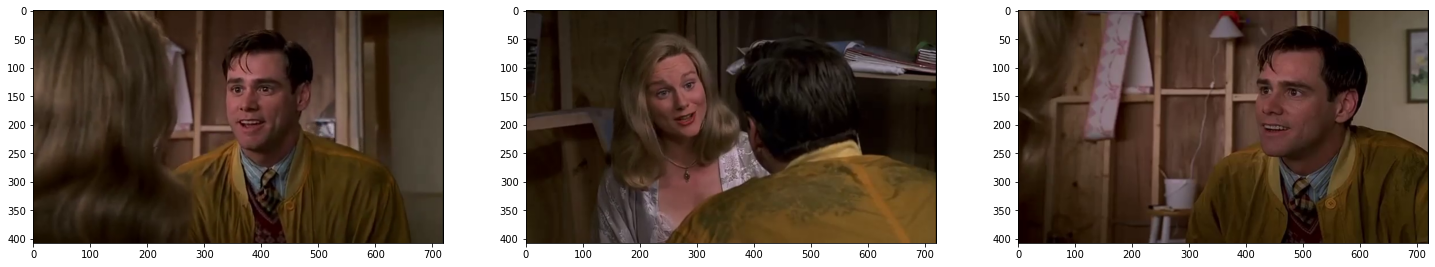

In [15]:
image_list = []
image_list.append(video_np[FRAME_TEST_LIST[0]])
image_list.append(video_np[FRAME_TEST_LIST[1]])
image_list.append(video_np[FRAME_TEST_LIST[2]])
DAN.showImage(image_list)

# Поиск и выделение лиц на 3 х изображениях

Изображение: 1, лицо: 1, Джим Керри: ДА, Евлидово расстояние: 0.4926
Изображение: 2, лицо: 1, Джим Керри: НЕТ, Евлидово расстояние: 0.8814
Изображение: 3, лицо: 1, Джим Керри: ДА, Евлидово расстояние: 0.447


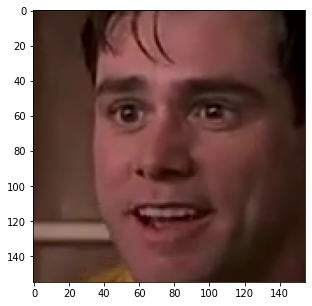

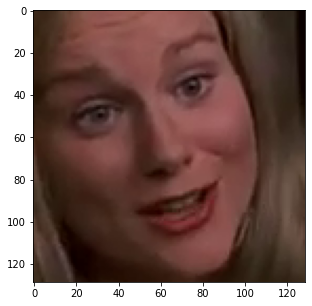

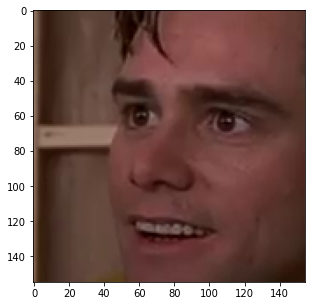

In [16]:


for i in range(3):
  image_list, desc_list = DAN.getRectangle(video_np[FRAME_TEST_LIST[i]])

  # Рассчитываем евклидово расстояние для найденых лиц и лица Джима Керри
  for j, desc in enumerate(desc_list):
    dist = DAN.euclideanDistance(desc, desc_dk_0)
    answer = 'ДА' if dist < DAN.threshold else 'НЕТ'
    print(f'Изображение: {(i+1)}, лицо: {(j +1)}, Джим Керри: {answer}, Евлидово расстояние: {round(dist, 4)}')
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 5)
    ax.imshow(image_list[j])

## Поиск и запись кадров с Джимом Керри на всём видео

In [17]:
DAN.frame_list = []  # Очищаем список
time_start = time.time()
for i, image in enumerate(video_np):  # Перебираем кадры видео
  image_list, desc_list = DAN.getRectangle(video_np[i])

  for j, desc in enumerate(desc_list):  # Перебираем найденные лица на видео
    dist = DAN.euclideanDistance(desc, desc_dk_0)
    if dist < DAN.threshold:  # Найден Джим Керри
      DAN.frame_list.append(i)
      continue

  if i % 100 == 0:
    delta_time = time.time() - time_start
    print(f'Найдено кадров с Джимом Керри: {len(DAN.frame_list)} из: {i}, время работы {round(delta_time)} c')

result_frame_list = DAN.frame_list
print('--- ИТОГО: ---')
print (f'Найдено кадров с Джимом Керри: {len(DAN.frame_list)} из: {i}')

Найдено кадров с Джимом Керри: 0 из: 0, время работы 0 c
Найдено кадров с Джимом Керри: 1 из: 100, время работы 19 c
Найдено кадров с Джимом Керри: 81 из: 200, время работы 39 c
Найдено кадров с Джимом Керри: 124 из: 300, время работы 58 c
Найдено кадров с Джимом Керри: 137 из: 400, время работы 77 c
Найдено кадров с Джимом Керри: 237 из: 500, время работы 96 c
Найдено кадров с Джимом Керри: 272 из: 600, время работы 115 c
Найдено кадров с Джимом Керри: 272 из: 700, время работы 135 c
Найдено кадров с Джимом Керри: 302 из: 800, время работы 154 c
Найдено кадров с Джимом Керри: 302 из: 900, время работы 173 c
Найдено кадров с Джимом Керри: 302 из: 1000, время работы 191 c
Найдено кадров с Джимом Керри: 393 из: 1100, время работы 210 c
Найдено кадров с Джимом Керри: 413 из: 1200, время работы 229 c
Найдено кадров с Джимом Керри: 454 из: 1300, время работы 248 c
Найдено кадров с Джимом Керри: 554 из: 1400, время работы 267 c
Найдено кадров с Джимом Керри: 647 из: 1500, время работы 286 c


## Выводим информацию

In [18]:
test_movie_len = i/25
test_movie_m = test_movie_len // 60
test_movie_s = test_movie_len % 60
print(f'Тестовый видеоролик длинной: {int(test_movie_m)}м, {round(test_movie_s)}c')

result_movie_len = len(DAN.frame_list)/25
result_movie_m = result_movie_len // 60
result_movie_s = result_movie_len % 60
print(f'Итоговый видеоролик длинной: {int(result_movie_m)}м, {round(result_movie_s)}c')

Тестовый видеоролик длинной: 3м, 35c
Итоговый видеоролик длинной: 0м, 50c


## Сохранение полученного видео с Джимом Керри

In [19]:
if len(DAN.frame_list) == 0:  # Если модель объект DAN инициализировали заново DAN.frame_list - обнуляется
  DAN.frame_list = result_frame_list

DAN.saveMovie(video_np)

(1240, 408, 720, 3)


# РОЛИК ГОТОВ.
# **ВНИМАНИЕ!**

Открывается не всеми проигрывателями. Но прекрасно открывается в браузере. Просто нажмите на ролик в Google Disc

Ролик находится в папке 'files/single_result' относительно папки проекта

Dlib - мощная библиотека. Обратите внимание на 22 секунду ролика!

In [21]:
mp4 = open(DAN.output_video_file, 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""<video width=720 controls><source src="%s" type="video/mp4"></video>""" % data_url)

Output hidden; open in https://colab.research.google.com to view.

# ИТОГИ:

## Выведем вектор дескриптора лица Джими Керри.
Пригодится в следующем эксперименте.

In [22]:
print(np.array(desc_dk_0, dtype=np.float32).tolist())

[-0.05413726717233658, 0.20258700847625732, -0.02980971336364746, -0.009266268461942673, -0.11678464710712433, 0.07381494343280792, -0.06925348937511444, -0.06044156849384308, 0.2005159556865692, 0.024151720106601715, 0.18836179375648499, 0.049733638763427734, -0.24746623635292053, 0.021895507350564003, -0.05165024474263191, 0.12912672758102417, -0.207529217004776, -0.0803472101688385, -0.1228303462266922, -0.04064009338617325, 0.049077291041612625, 0.0820658951997757, 0.044419772922992706, 0.08841884136199951, -0.13434597849845886, -0.30047282576560974, -0.06881625205278397, -0.17035093903541565, 0.01376345194876194, -0.2013019621372223, 0.004748144187033176, -0.030011259019374847, -0.20061665773391724, -0.10102177411317825, 0.011843681335449219, 0.07204631716012955, -0.16505970060825348, -0.1117887943983078, 0.2104894369840622, 0.10288297384977341, -0.10170906782150269, 0.03403836488723755, 0.017056070268154144, 0.33924412727355957, 0.18967221677303314, 0.007659764960408211, -0.00553

## Возможности улучшения
1. Берём не одно изображение Джима Керри, а множество.
2. Составляем список векторов дескрипторов.
3. Находим среднее значение - средний вектор
4. Для определения сходства лиц используем найденный средний вектор для Джима Керри.